### Import modules

In [23]:
%matplotlib inline


import squarify # Treemap Ploting
import geopandas
from shapely.geometry import Point

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

# Num visible columns in dataframe
pd.set_option('display.max_columns', 50)
# Activate Seaborn
sns.set()
# Large Plot
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
# Use ggplot style
style.use('ggplot')

## Load data

In [51]:
df_loans = pd.read_csv('./data/kiva_loans.csv')
df_mpi = pd.read_csv('./data/kiva_mpi_region_locations.csv')
df_theme_region = pd.read_csv('./data/loan_themes_by_region.csv')
df_theme_ids = pd.read_csv('./data/loan_theme_ids.csv')

### First look at the loans

In [25]:
df_loans.head(2)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01


#### Key column descriptions:

* id: Unique ID for loan
* loan_amount: Requestet loan amount [USD]
* sector: High level category
* use: Exact usage of loan amount
* country: Full country name of country in which loan was disbursed
* posted_time: The time at which the loan is posted on Kiva by the field agent
* disbursed_time: The time at which the loan is disbursed by the field agent to the borrower
* funded_time: The time at which the loan posted to Kiva gets funded by lenders completely
* lender_count: The total number of lenders that contributed to this loan
* borrower_genders: Comma separated M,F letters, where each instance represents a single male/female in the group


In [26]:
print("Unique values in column \n")

for col in df_loans.columns:
    print("{} : {}".format(col, df_loans[col].nunique()))

Unique values in column 

id : 671205
funded_amount : 610
loan_amount : 479
activity : 163
sector : 15
use : 424912
country_code : 86
country : 87
region : 12695
currency : 67
partner_id : 366
posted_time : 667399
disbursed_time : 5719
funded_time : 498007
term_in_months : 148
lender_count : 503
tags : 86719
borrower_genders : 11298
repayment_interval : 4
date : 1298


```
The dataset contains 671 206 loans to borrowers in 87 countries.
Intended use of money is varied across many activities.
The number of genders seems odd.
```

### Investigate genders

In [27]:
df_loans["borrower_genders"].value_counts()[:5]

female                            426502
male                              134710
female, female                     12164
female, female, female             11676
female, female, female, female      9052
Name: borrower_genders, dtype: int64

```
The gender of each recipient of a particular loan is included.
There seems to be a majority of female borrowers
```

In [58]:
# Total nummber of females
n_females = df_loans["borrower_genders"].str.count('female').sum()

# Total number of males
n_males = df_loans["borrower_genders"].str.count(r'^male').sum()

# New column where loans with multiple borrowers are given the gender "group"
df_loans["gender_simplified"] = ["single " + gender if gender in ["female", "male"] 
                                 else "group" for gender in df_loans["borrower_genders"]]

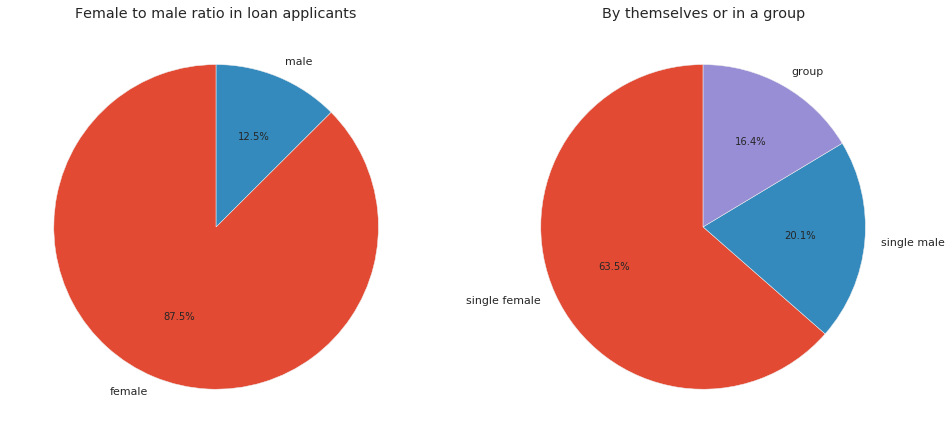

In [83]:
plt.subplot(1, 2, 1)
plt.pie(x=[n_females, n_males], labels=["female", "male"],
                  autopct='%1.1f%%', shadow=False, startangle=90)

plt.title("Female to male ratio in loan applicants")


plt.subplot(1, 2, 2)
plt.pie(x=df_loans["gender_simplified"].value_counts().values, 
                  labels=df_loans["gender_simplified"].value_counts().index,
                  autopct='%1.1f%%', shadow=False, startangle=90)

plt.title("By themselves or in a group")
 
plt.show()

### Missing value analysis

In [31]:
rows_with_nan = df_loans.isnull().any(axis=1).sum()
print("{} rows have one or more missing values".format(rows_with_nan))

248124 rows have one or more missing values


In [32]:
print("Missing values in column \n")

for col in df_loans.columns:
    print("{} : {}".format(col, df_loans[col].isnull().sum()))

Missing values in column 

id : 0
funded_amount : 0
loan_amount : 0
activity : 0
sector : 0
use : 4232
country_code : 8
country : 0
region : 56800
currency : 0
partner_id : 13507
posted_time : 0
disbursed_time : 2396
funded_time : 48331
term_in_months : 0
lender_count : 0
tags : 171416
borrower_genders : 4221
repayment_interval : 0
date : 0


```
Majority of missing data is in two of the columns, namely "use" and "funded time"
```

### Visualize country of origin of borrowers

In [33]:
# Extract coordinates from df_theme_region and convert them to Points
df_theme_region['coordinates'] = list(zip(df_theme_region['lon'], df_theme_region['lat']))
df_theme_region['coordinates'] = df_theme_region['coordinates'].apply(Point)

In [34]:
# Create GeoDataFrame and load map
gdf = geopandas.GeoDataFrame(df_theme_region[['country', 'coordinates']], geometry='coordinates')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

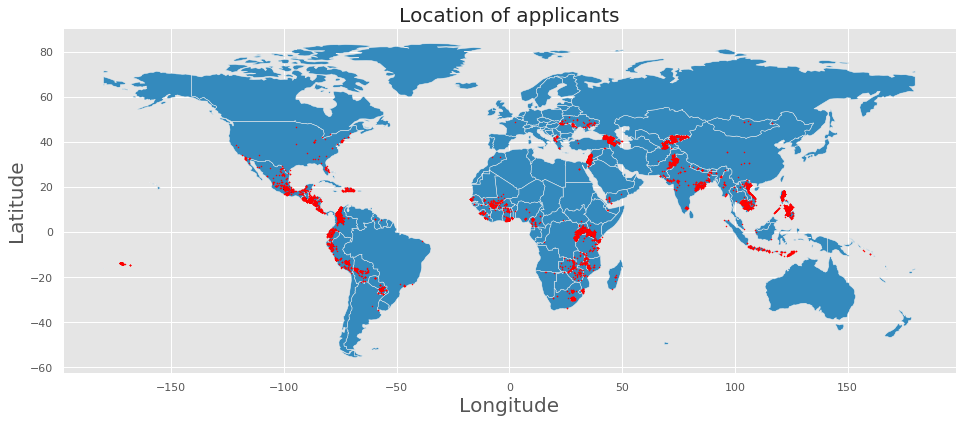

In [35]:
# Draw world
ax = world[(world.continent != 'Antarctica')].plot()

# Plot GeoDataFrame.
gdf.plot(ax=ax, color='red', markersize=1)

# Set labels
ax.set_title('Location of applicants', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_xlabel('Longitude', fontsize=20)

plt.show()

In [36]:
# If your geography skills are also lacking
df_theme_region[(df_theme_region['lat'].between(-20, 0)) & 
                 df_theme_region['lon'].between(-200, -150)]['country'].unique()

array(['Samoa'], dtype=object)

```
Borrowers are primarily located in poorer countries. A treemap might be more informative
```

In [37]:
# Number of applications (from a country) relative to total number of applications
prct_applic = df_loans["country"].value_counts(normalize=True, dropna=False)[:25]

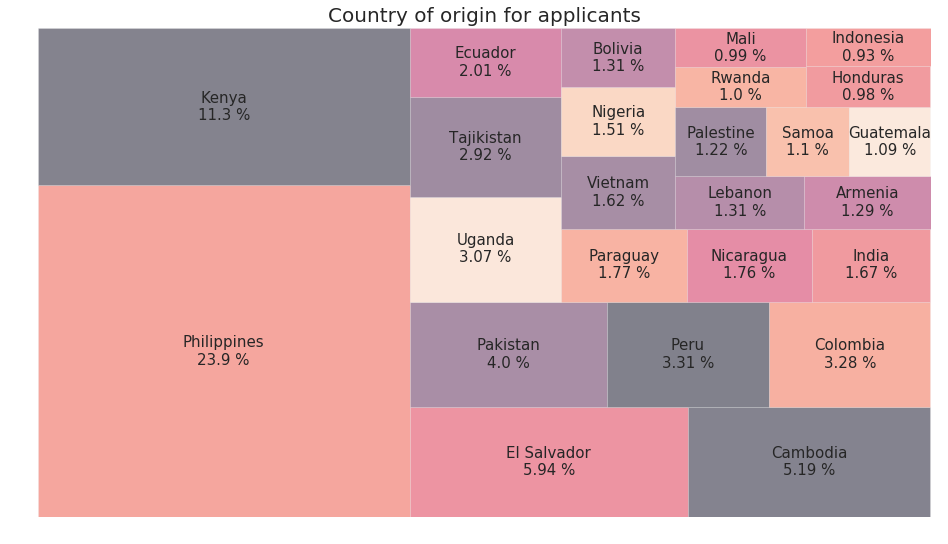

In [38]:
squarify.plot(sizes=prct_applic.values, label=prct_applic.index  + '\n' + 
              np.round(np.multiply(prct_applic.values, 100), decimals=2).astype(str) + ' %', 
              alpha=.5, text_kwargs={"fontsize":15})

plt.axis('off')
plt.title('Country of origin for applicants', fontsize=20)

plt.show()

```
The Philippines and Kenya account for more than 30 % of the applications
```

### What's the intended use of the loans?

In [39]:
# Number of applications to a sector relative to total number of applications for all sectors
prct_sector = df_loans["sector"].value_counts(normalize=True)[:10]

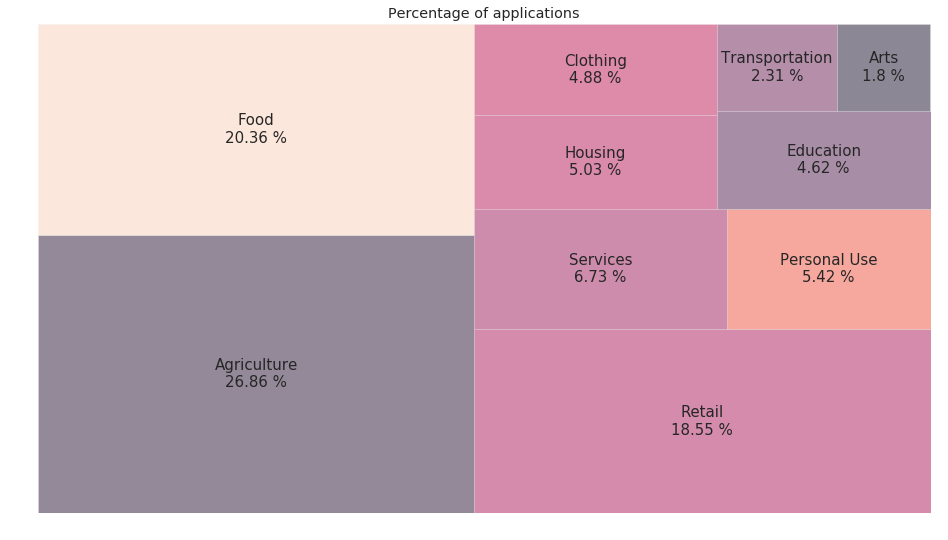

In [40]:
squarify.plot(sizes=prct_sector.values, label=prct_sector.index  + '\n' + 
              np.round(np.multiply(prct_sector.values, 100), decimals=2).astype(str) + ' %', 
              alpha=.5, text_kwargs={"fontsize":15})

plt.axis('off')
plt.title('Percentage of applications')
plt.show()

```
Agriculture and Food account for nearly 50 % of the applications
```

##### Some uses within the agriculture sector

In [47]:
uses = df_loans[df_loans["sector"].str.contains("Agriculture")]
for i in range(5):
    print(uses["use"].iloc[i])

To purchase a dairy cow and start a milk products business .
to expand her existing  poultry farm business.
to purchase potato seeds and fertilizers for growing potatoes on her own land.
to purchase potato seeds and fertilizers for growing potatoes.
to purchase potato seeds and fertilizer for farming potatoes.


##### Most popular intended use overall

In [48]:
df_loans["use"].value_counts()[:10]

to buy a water filter to provide safe drinking water for their family.    5217
to buy a water filter to provide safe drinking water for her family.      4082
To buy a water filter to provide safe drinking water for their family.    2141
to build a sanitary toilet for her family.                                1708
to build a sanitary toilet for her family                                 1599
to buy ingredients for her food production business                       1419
to purchase more groceries to sell.                                       1409
to buy feed and other supplies to raise her pigs.                         1405
to buy fertilizers and other farm supplies.                               1280
to buy a water filter to provide safe drinking water for his family.      1261
Name: use, dtype: int64

### Analyze requestet loan amount

#### Within sectors

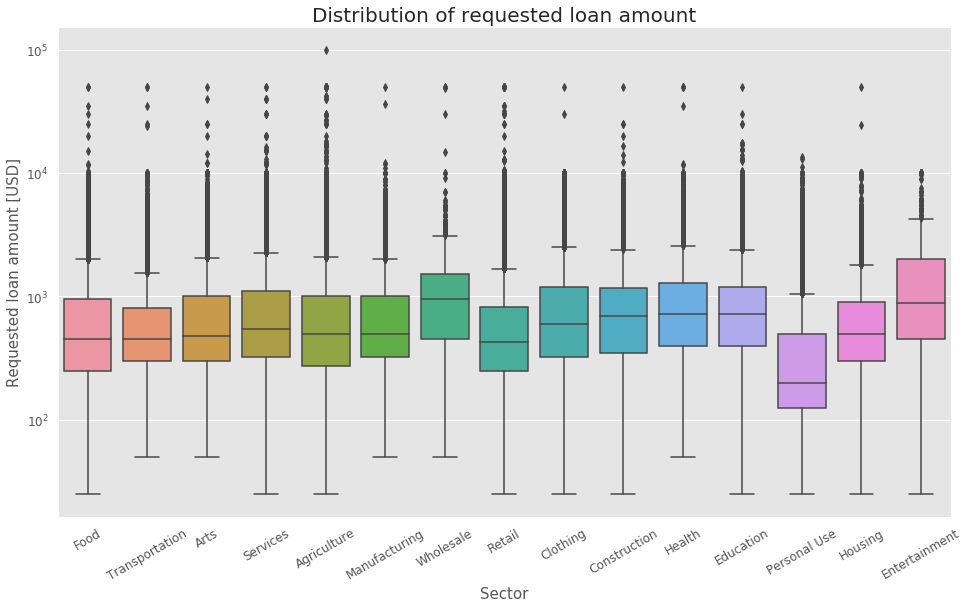

In [43]:
ax = sns.boxplot(x=df_loans["sector"], y=df_loans["loan_amount"])

ax.set(yscale="log")

# Set labels
ax.set_title('Distribution of requested loan amount', fontsize=20)
ax.set_ylabel('Requested loan amount [USD]', fontsize=15)
ax.set_xlabel('Sector', fontsize=15)

plt.yticks(fontsize=12)
plt.xticks(rotation=30, fontsize=12)

plt.show()

```
The median requested loan amount is between 100$ and 1000$ for all sectors.
The largest requested loan amount is 100 000$ in the Agriculture sector.
```

#### Intented use for the application requesting 100 000 USD

In [44]:
df_loans["use"].iloc[df_loans["loan_amount"].values.argmax()]

'create more than 300 jobs for women and farmers in rural Haiti.'

#### Some statistics regarding requestet loan amount for each sector

In [45]:
df_loans.groupby("sector").loan_amount.agg(["min","max","median","mean","sum"]).\
astype(int).sort_values(by="sum", ascending=False).T

sector,Agriculture,Food,Retail,Services,Clothing,Education,Housing,Personal Use,Arts,Transportation,Health,Construction,Manufacturing,Entertainment,Wholesale
min,25,25,25,25,25,25,25,25,50,50,50,25,50,25,50
max,100000,50000,50000,50000,50000,50000,49750,13425,50000,50000,50000,50000,50000,10000,50000
median,500,450,425,550,600,725,500,200,475,450,725,700,500,887,950
mean,793,889,788,1064,1139,998,701,411,1014,713,1067,1068,877,1673,1569
sum,143067875,121606150,98122900,48057450,37300925,30968525,23663950,14955350,12240325,11066900,9843400,6695150,5447900,1389150,995200
